In [1]:
%matplotlib inline
import glymur
# from IPython.display import Image
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import numpy as np
import json, os
from glob import glob
from PIL import Image
from tqdm import tnrange, tqdm

In [2]:
config = json.load(open(os.path.expanduser("~/.thesis.conf")))
db_folder = Path(config['datasets']) / 'hisdb'
modules   = Path(config['project']) / 'src'

%load_ext autoreload
%autoreload 2
import sys
sys.path.append(str(modules))

In [4]:
# name = "artofavantgardei00rowe"
# db_path = Path("/media/jakob/bigdata/datasets/archive_org/")
# jp2_folder = db_path / "*" / ("*" + "_jp2")
# files = glob((str(jp2_folder / "*.jp2")))

In [3]:

from datasets.divahisdb import HisDBDataset
dataset = HisDBDataset(db_folder)
page = dataset[0]

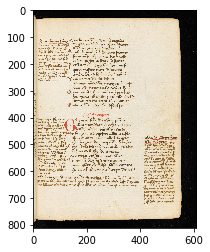

In [4]:
plt.imshow(np.array(page)[::8,::8])

In [5]:
# import the necessary packages
import skimage.io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float, img_as_ubyte
from skimage.transform import resize, rotate
from skimage import io
import matplotlib.pyplot as plt
import argparse
 
import random as rnd

In [7]:
 # loop over the number of segments
# for numSegments in (200,201):
#     # apply SLIC and extract (approximately) the supplied number
#     # of segments
#     segments = slic(image, n_segments = numSegments, sigma = 5)

#     # show the output of SLIC
#     fig = plt.figure("Superpixels -- %d segments" % (numSegments))
#     ax = fig.add_subplot(1, 1, 1)
#     ax.imshow(mark_boundaries(image, segments,color=(0, 0, 0)))
#     plt.axis("off")

# show the plots
# plt.show()

In [43]:
scale = 2**-3
scaled = page.resize((int(page.width * scale), int(page.height * scale)))
image = img_as_float(np.array(scaled))
# scaled

In [12]:
patch = img_as_float(page.crop((700,700,1200,1200)))

In [44]:
segments = slic(image, n_segments = 3000)

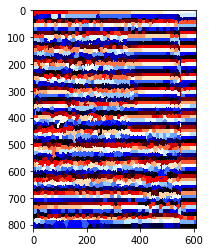

In [45]:
plt.imshow(segments,cmap='flag')

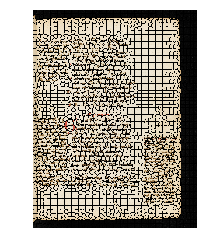

In [49]:
fig = plt.figure("Superpixels -- %d segments" % (numSegments))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments,color=(0, 0, 0)))
plt.axis("off")
plt.show()

In [50]:
# patches = np.zeros((5, 28, 28, 3))
segments.dtype
segments

array([[   0,    0,    0, ...,   46,   46,   46],
       [   0,    0,    0, ...,   46,   46,   46],
       [   0,    0,    0, ...,   46,   46,   46],
       ...,
       [2293, 2293, 2293, ..., 2329, 2329, 2329],
       [2293, 2293, 2293, ..., 2329, 2329, 2329],
       [2293, 2293, 2293, ..., 2329, 2329, 2329]])

In [29]:
def img_offsets(directions=[0], width=28, shitter=7):
    offsets = np.zeros((len(directions), 2))
    for idx, direction in enumerate(directions):
        print(direction)
        offset[idx] = [width * direction[0]  + rnd.randint(-shitter,shitter),
                       width * direction[1]  + rnd.randint(-shitter,shitter)]
    return offsets

In [30]:
patch_width = 28
rnd_offset = 7
nsegments = 15 # np.max(segments)
patches = np.zeros((nsegments, patch_width, patch_width, 3),dtype=np.ubyte)
def centered_patch(image, m, n, width, offset=[0,0]):
    return image[int(m + offset[0] - width + 0.5):
                 int(m + offset[0] + width + 0.5),
                 int(n + offset[1] - width + 0.5):
                 int(n + offset[1] + width + 0.5)]


# np.max(segments)
for snum in tqdm(range(0, nsegments)):
    spixel = np.where(segments == snum)
    mmin, nmin = list(map(min,spixel))
    mmax, nmax = list(map(max,spixel))
    # center 
    m, n = int(mmin + (mmax - mmin)/2), int(nmin + (nmax - nmin)/2)
    width = min(mmax - mmin, nmax - nmin) / 2
    offsets = img_offsets([[0,0],[0,1]])
    
    for idx, offset in enumerate(offsets):
        patch = centered_patch(image, m, n, width)
        if (np.all(patch.shape[0:2] == width * 2)):
            print(snum, patch.shape)
            patch = img_as_ubyte(patch)
            small = resize(patch, (patch_width,patch_width))
            patches[snum] = small
#             plt.imsave('segments/patch{}_{}.png'.format(snum,idx),small)
        else:
            pass
#             print(patch.shape[0:2])
    

  0%|          | 0/15 [00:00<?, ?it/s]

[0, 0]


NameError: name 'offset' is not defined

/home/jakob/miniconda3/envs/master/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jakob/miniconda3/envs/master/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


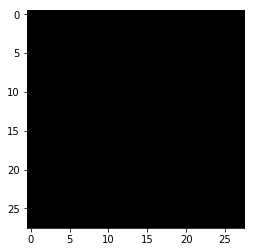

In [50]:
patch = centered_patch(image, m, n, width,offset)
patch = img_as_ubyte(patch)
small = resize(patch, (28,28))
patches[1] = small

plt.imshow(patches[0])

In [144]:
a = img_offsets([[0,0],[0,1]])
a[1] = [2,2]
width * [0,1][0]  + rnd.randint(-7,7)

[0, 0]
[0, 1]


4.0

In [95]:
patch.shape[0:2]

(0, 23)

In [111]:
pimg = np.reshape(patches[:2], (2*28, 28, 3))
pimg.shape
# plt.imshow(pimg)
pimg[:28,:,:]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

/home/jakob/miniconda3/envs/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


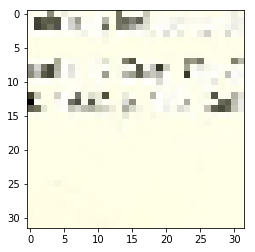

In [136]:
plt.imshow(resize(patch, (32,32)))

In [52]:
img_as_int?